# Machine Translation

English-German Translation using encoder-decoder model 

Applying out of vocabulary concept

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [1]:
# What's life without style :). So, let's add style to our dataframes
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [0]:
import pandas as pd 
import string 
import pickle
from pickle import dump
from pickle import load
from string import digits
import re 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from numpy import array, argmax, random, take 
import matplotlib.pyplot as plt 
%matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [4]:
from keras.models import Model
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding,Input,RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model 
from keras import optimizers 

Using TensorFlow backend.


In [5]:
!  pip install version_information

In [6]:
# first install: pip install version_information
%reload_ext version_information
%version_information pandas,re,sklearn, matplotlib,keras

Software versions
Python 3.6.8 64bit [GCC 8.0.1 20180414 (experimental) [trunk revision 259383]
IPython 5.5.0
OS Linux 4.14.137+ x86_64 with Ubuntu 18.04 bionic
pandas 0.24.2
re 2.2.1
sklearn 0.21.3
matplotlib 3.0.3
keras 2.2.5
Fri Sep 13 12:25:50 2019 UTC

# 2)- Reading Dataset

In [0]:
df= pd.read_pickle('data_random_oov.pkl')

In [8]:
df.shape

(2169, 2)

In [9]:
df[30:35]

,eng,ger
30,when the united states unk unk after world war ii general unk unk and his unk unk the country to unk a unk unk to unk that unk unk unk unk would be unk with democracy,als die unk staaten nach dem zweiten unk unk unk unk unk unk unk unk und sein unk das land dazu eine unk zu unk die unk unk dass die unk unk unk unk durch demokratie unk wurde
31,unk unk that workers and their unk had a role to play in unk the new unk they included unk that unk unk that the right of workers to organize and to unk and act unk is unk,in unk unk dessen dass die arbeiter und ihre gewerkschaften bei der unk eines neuen unk eine rolle einnahmen unk sie eine unk die unk unk dass die rechte der arbeiter auf unk und unk unk und unk u...
32,when the united states unk germany after world war ii general unk unk unk and his unk unk the unk to unk a unk that would unk that unk unk unk was unk with unk democracy,als die unk staaten nach dem zweiten unk deutschland unk unk unk unk unk unk und sein unk die deutschen eine unk zu unk die dafur sorgen wurde dass der unk unk unk durch eine starke demokratie unk...
33,unk that workers would need to organize and make their unk heard in the new unk the unk included a unk that unk unk the right to form unk to unk and unk working and economic conditions shall be un...,in unk der unk dass die arbeiter sich wurden unk mussen und ihre stimme in der neuen unk unk sollten unk die deutschen eine unk ein die unk unk das recht unk zu unk um die unk und wirtschaftlichen...
34,unk that unk or unk to unk this right shall be unk and unk unk unk to this end shall be unk,unk die dieses recht unk oder darauf unk es zu unk sind unk und unk darauf unk manahmen sind unk


# 3)- Quick Preprocessing

In [0]:
# Lowercase all characters
df.eng=df.eng.apply(lambda x: x.lower())
df.ger=df.ger.apply(lambda x: x.lower())

In [0]:
# Remove quotes
df.eng=df.eng.apply(lambda x: re.sub("'", '', x))
df.ger=df.ger.apply(lambda x: re.sub("'", '', x))

In [0]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
df.eng=df.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
df.ger=df.ger.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [0]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
df.eng=df.eng.apply(lambda x: x.translate(remove_digits))
df.ger=df.ger.apply(lambda x: x.translate(remove_digits))

In [0]:
# Remove extra spaces
df.eng=df.eng.apply(lambda x: x.strip())
df.ger=df.ger.apply(lambda x: x.strip())
df.eng=df.eng.apply(lambda x: re.sub(" +", " ", x))
df.ger=df.ger.apply(lambda x: re.sub(" +", " ", x))

In [0]:
# Add start and end tokens to target sequences. I am not German so , I am doing so for my ease
df.ger = df.ger.apply(lambda x : 'START_ '+ x + ' _END')

In [16]:
df.ger[70:73]

70             START_ dr unk sagte dass das alter einer frau bei der diagnose der unk des unk unk unk sowie der unk und unk status ebenfalls die unk unk _END
71                                                   START_ fur altere frauen und diejenigen deren unk zum unk bereits weiter unk war lag die unk am unk _END
72    START_ fur diejenigen die in landlichen und unk regionen des staates unk lag das unk wahrend der studie um prozent hoher als fur diejenigen in unk _END
Name: ger, dtype: object

In [17]:
df.sample(10)

,eng,ger
2082,the unk standing committee on sunday unk a unk to let only two or three candidates run in hong kongs unk vote,START_ der unk unk des nationalen unk unk am sonntag ein unk das lediglich zwei oder drei kandidaten fur die unk in hongkong im jahre unk _END
557,perry has unk not unk and called the charges a political unk,START_ perry unk auf nicht unk und unk die anklage einen politischen unk _END
605,unk view unk unk whose unk unk is unk for the man unk unk,START_ unk des unk unk unk dessen unk unk auf der unk fur den man unk preis steht _END
659,are my feet too big,START_ sind meine fue zu gro _END
186,on the israeli side soldiers and six unk including a unk unk were killed,START_ auf unk seite wurden soldaten und sechs unk darunter ein unk arbeiter getotet _END
2152,the boy had unk down to unk in the morning only to immediately go back up again,START_ der junge war am morgen nach unk unk um unk darauf wieder auf die hohe zu unk _END
983,unk unk unk unk set a trial unk in unk,START_ unk unk unk unk unk das unk fur unk an _END
1532,unk unk are unk ground again in east ukraine,START_ in der ostukraine sind die unk unk weiter auf dem unk _END
913,i wanted to fight for my country but it will not happen,START_ ich wollte fur mein land kampfen aber das wird nicht geschehen _END
655,nothing else he wanted to see,START_ es gab nichts was er sonst hatte sehen wollen _END


### 3a)- Vocab Size

In [0]:
# Vocabulary of English
all_eng_words=set()
for eng in df.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
# Vocabulary of German 
all_german_words=set()
for ger in df.ger:
    for word in ger.split():
        if word not in all_german_words:
            all_german_words.add(word)

In [19]:
# Max Length of source sequence
import numpy as np
lenght_list=[]
for l in df.eng:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)
max_length_src

71

In [20]:
# Max Length of target sequence
lenght_list=[]
for l in df.ger:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)
max_length_tar

73

In [21]:
df['word_eng'] = df['eng'].apply(lambda x: len(str(x).split(" ")))
df[['eng','word_eng']].sample(3)

,eng,word_eng
1400,unk unk that the unk was there from between the first and unk unk unk unk until the unk of the unk people in the former roman unk,28
1199,unk unk may have been lost,6
138,the unk conditions are believed to have unk to the delayed unk of a unk unk flight from unk to adelaide,21


In [22]:
# adding +2 due to adding of START and END
df['word_ger'] = df['ger'].apply(lambda x: len(str(x).split(" ")))
df[['ger','word_ger']].sample(3)

,ger,word_ger
1867,START_ unk unk der unk die unk unk unk unk wird unk die unk fur die unk bei unk da man so sicher sein kann das richtige unk zu finden _END,31
729,START_ sie gehen zu weit sagte er wenn sie unk als unk unk die unsere unk vielleicht oder auch nicht unk haben _END,23
1854,START_ auer unk und amazon ist auch unk von unk unk eine unk unk fur unk bucher _END,18


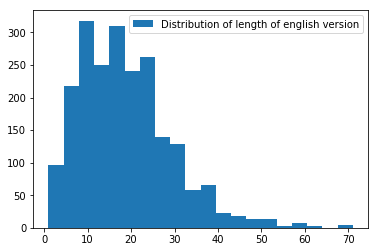

In [23]:
words_eng=df['word_eng']
plt.hist(words_eng, bins=20, label="Distribution of length of english version") 
plt.legend() 
plt.show()

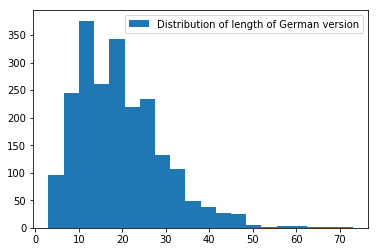

In [24]:
words_ger=df['word_ger']
plt.hist(words_ger, bins=20, label="Distribution of length of German version") 
plt.legend() 
plt.show()

### 3b)-Words' frequency

In [25]:
# let’s check the 10 most frequently occurring words in our English text data
freq_eng = pd.Series(' '.join(df['eng']).split()).value_counts()[:10]
freq_eng

unk     9455
the     2643
to      1115
of      1078
in      1015
and      953
a        903
for      423
that     410
is       400
dtype: int64

In [26]:
freq_ger = pd.Series(' '.join(df['ger']).split()).value_counts()[:12]
freq_ger

unk       11732
START_     2169
_END       2169
die        1256
der        1177
und         940
in          790
den         453
von         433
das         426
zu          406
fur         333
dtype: int64

As we have start and end words so, I did check 12 so that we get idea of most fequent words

**How about least occuring words**

In [27]:
less_freq_eng = pd.Series(' '.join(df['eng']).split()).value_counts()[-10:]
less_freq_eng

trainees     5
hospitals    5
hadnt        5
greatest     5
fall         5
wall         5
answer       5
alyona       5
band         5
exercise     5
dtype: int64

In [28]:
less_freq_ger = pd.Series(' '.join(df['ger']).split()).value_counts()[-10:]
less_freq_ger

standen          5
steigt           5
informationen    5
fuhrt            5
rasse            5
feministinnen    5
kiefer           5
straen           5
angeblich        5
kindern          5
dtype: int64

### 3a)- Defining input and target

In [29]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_german_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_german_words)
num_encoder_tokens, num_decoder_tokens

(1211, 991)

In [30]:
num_decoder_tokens += 1 # For zero padding
num_decoder_tokens

992

In [0]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [0]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [33]:
print(reverse_input_char_index)

{1: 'a', 2: 'abandoned', 3: 'abbott', 4: 'able', 5: 'abortions', 6: 'about', 7: 'above', 8: 'access', 9: 'according', 10: 'account', 11: 'accused', 12: 'across', 13: 'act', 14: 'action', 15: 'actions', 16: 'activists', 17: 'actually', 18: 'addition', 19: 'adelaide', 20: 'admitting', 21: 'affected', 22: 'africa', 23: 'after', 24: 'again', 25: 'against', 26: 'age', 27: 'ago', 28: 'agreed', 29: 'agreement', 30: 'ahead', 31: 'ailinn', 32: 'air', 33: 'airport', 34: 'all', 35: 'allow', 36: 'almost', 37: 'alone', 38: 'along', 39: 'already', 40: 'also', 41: 'although', 42: 'always', 43: 'alyona', 44: 'am', 45: 'amazon', 46: 'america', 47: 'american', 48: 'americans', 49: 'among', 50: 'amount', 51: 'an', 52: 'and', 53: 'andrew', 54: 'anniversary', 55: 'announced', 56: 'announcement', 57: 'annual', 58: 'another', 59: 'answer', 60: 'any', 61: 'anyone', 62: 'apollo', 63: 'april', 64: 'are', 65: 'area', 66: 'areas', 67: 'arm', 68: 'army', 69: 'around', 70: 'as', 71: 'asbestos', 72: 'asked', 73: 'as

In [34]:
print(reverse_target_char_index)

{1: 'START_', 2: '_END', 3: 'ab', 4: 'abbott', 5: 'abend', 6: 'aber', 7: 'abtreibungen', 8: 'adelaide', 9: 'ailinn', 10: 'aljona', 11: 'all', 12: 'alle', 13: 'allein', 14: 'allem', 15: 'allen', 16: 'aller', 17: 'allerdings', 18: 'alles', 19: 'als', 20: 'also', 21: 'alt', 22: 'alten', 23: 'alter', 24: 'altere', 25: 'am', 26: 'amazon', 27: 'amerikanischen', 28: 'an', 29: 'andere', 30: 'anderem', 31: 'anderen', 32: 'anders', 33: 'andrew', 34: 'anfang', 35: 'angaben', 36: 'angeblich', 37: 'angeboten', 38: 'angekundigt', 39: 'angst', 40: 'anklage', 41: 'anstieg', 42: 'anteil', 43: 'apollo', 44: 'april', 45: 'arbeit', 46: 'arbeiten', 47: 'arbeiter', 48: 'arbeitete', 49: 'arbeitsplatz', 50: 'armee', 51: 'art', 52: 'arzt', 53: 'arzte', 54: 'arzten', 55: 'asbest', 56: 'asbestkontakt', 57: 'auch', 58: 'auer', 59: 'auerdem', 60: 'auf', 61: 'aufgabe', 62: 'aufgenommen', 63: 'aufgerufen', 64: 'aufgrund', 65: 'aufhoren', 66: 'augen', 67: 'august', 68: 'aus', 69: 'ausbildung', 70: 'ausgaben', 71: 'au

### 3b)-Train - Test Split

For validation

In [35]:
X, y = df.eng, df.ger #X being input, y being target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, X_test.shape

((1735,), (434,))

**Save the train and test dataframes for reproducing the results later, as they are shuffled**

In [0]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

In [0]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

# 4)-Encoder - Decoder Model Architecture

In [0]:
latent_dim = 50

In [39]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [41]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [0]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 15

In [44]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     60550       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 50)     49600       input_2[0][0]                    
____________________________________________________________________________________________

In [45]:
history=model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)


Epoch 1/15
13/13 [==============================] - 7s 547ms/step - loss: 6.4949 - acc: 0.2698 - val_loss: 5.6377 - val_acc: 0.2955
Epoch 2/15
13/13 [==============================] - 5s 370ms/step - loss: 5.1829 - acc: 0.2963 - val_loss: 4.7831 - val_acc: 0.2972
Epoch 3/15
13/13 [==============================] - 5s 378ms/step - loss: 4.6196 - acc: 0.2978 - val_loss: 4.5312 - val_acc: 0.2988
Epoch 4/15
13/13 [==============================] - 5s 367ms/step - loss: 4.4845 - acc: 0.2958 - val_loss: 4.5018 - val_acc: 0.2964
Epoch 5/15
13/13 [==============================] - 5s 374ms/step - loss: 4.4536 - acc: 0.2968 - val_loss: 4.5115 - val_acc: 0.2955
Epoch 6/15
13/13 [==============================] - 5s 366ms/step - loss: 4.4442 - acc: 0.2970 - val_loss: 4.4748 - val_acc: 0.2972
Epoch 7/15
13/13 [==============================] - 5s 371ms/step - loss: 4.4406 - acc: 0.2966 - val_loss: 4.4719 - val_acc: 0.2988
Epoch 8/15
13/13 [==============================] - 5s 369ms/step - loss: 4

In [0]:
# save model
model.save_weights('translate.h5')

In [0]:
model.load_weights('translate.h5')

# 5)-Inference Setup

In [0]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

# Decode sample sequeces

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']
  

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

# 6)- Plotting results

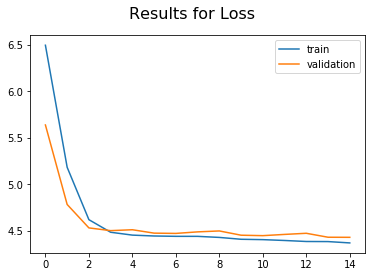

In [50]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['train','validation']) 
plt.suptitle('Results for Loss', fontsize=16)
plt.show()

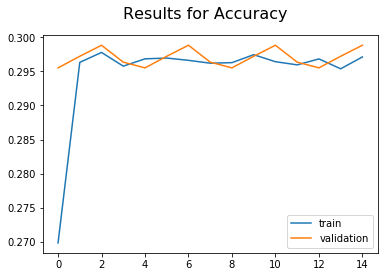

In [51]:
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc']) 
plt.legend(['train','validation']) 
plt.suptitle('Results for Accuracy', fontsize=16)
plt.show()

Although model is giving better results than previous attempt yet we see same pattern of straight-wise plot in validation case. There is no overfitting and results have improved. Let's see what else could be done? If we add more data i.e full data points then this might work better. It didn't work well at all.

So, next is to check with evaluation matrics ! 